In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from scipy.ndimage.interpolation import zoom
from sklearn.preprocessing import normalize
from skimage.transform import rotate
import matplotlib.pyplot as plt
import pickle
import librosa
import glob
import re
import sys
import os
import mido
from tqdm import tqdm_notebook
from mido import MidiFile
import gc

from sheet_id.models.DWD import DWD
from sheet_id.utils.dwd_utils import generateFullpagePrediction, inferBoundingBoxes
from sheet_id.utils.base_utils import visualizeBoundingBoxes

Using TensorFlow backend.
/data1/mjenrungrot/ISMIR2019-bootleg/sheet-midi-sync/sheet_id/utils/base_utils.py:23: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(stream)


### Load strips

All pkl data lies in this directory

In [3]:
pkl_dir = 'score_data/pkl_data'

In [4]:
def sort_nicely(l):
    d = {}
    for elem in l:
        m = re.search('\S+-(\d+)\.pkl', elem)
        if m:
            idx = int(m.group(1))
            d[idx] = elem
        else:
            print('Failed regular expression matching: %s' % (elem))
            sys.exit(1)
    sorted_filenames = [d[key] for key in sorted(d.keys())]
    return sorted_filenames

In [5]:
def loadStripData(basename):
    pkl_files = sort_nicely(glob.glob(pkl_dir + '/' + basename + '-*.pkl'))
    strips = []
    for pkl_file in pkl_files:
        with open(pkl_file, 'rb') as f:
            d = pickle.load(f)
            strips.extend(d['strips'])
    return strips

In [6]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

In [7]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

In [8]:
scoreFile = 'mendelssohn_op62no3_v2'

In [9]:
strips = loadStripData(scoreFile)

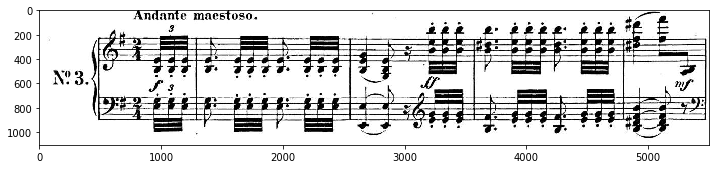

In [10]:
showImage(strips[0])

### Sheet music strip analysis

In [11]:
def rotateToHorizontal(img, lb=-.5, ub=.5, incr=.02, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result

In [12]:
def fitStaffLines(scores, height):
    N = len(scores)
    idx_RH, idx_LH, best_score = 0, 0, -1
    idxs_sorted = np.argsort(scores)[::-1]
    min_separation = int(height * 1.66)
    idx1 = idxs_sorted[0]
    for j in range(1, N):
        idx2 = idxs_sorted[j]
        curScore = scores[idx1] + scores[idx2]
        sep = np.abs(idx1 - idx2)
        if sep > min_separation and curScore > best_score:
            best_score = curScore
            idx_RH = min(idx1, idx2)
            idx_LH = max(idx1, idx2)
            break
    return best_score, idx_RH, idx_LH

In [13]:
def locateStaffLines(s, min_height = 60, max_height = 120, plot = False):
    rsums = np.sum(s, axis=1)
    bestScore = 0
    lineLocs = np.zeros(10)
    for h in range(min_height,max_height+1):
        idxs = h * np.arange(5) / 4.0
        idxs = idxs.round().astype('int')
        filt = np.zeros(h+1)
        filt[idxs] = 1 # create comb filter
        scores = np.convolve(rsums, filt, 'valid')
        curScore, idx_RH, idx_LH = fitStaffLines(scores, h)
        if curScore > bestScore:
            bestScore = curScore
            lineLocs[0:5] = idxs + idx_RH
            lineLocs[5:] = idxs + idx_LH
    
    if plot:
        plt.plot(rsums)
        for i in range(len(lineLocs)):
            plt.axvline(x=lineLocs[i], color='r', linewidth=1)
        plt.show()
        
    return lineLocs

In [14]:
def calcStaffLineLocs(strips):
    result = np.zeros((len(strips),10))
    for i, strip in enumerate(strips):
        result[i,:] = locateStaffLines(strip, max_height = int(strip.shape[0]/4))
    return result

In [15]:
def findMedianStaffHeight(strips):
    staffLines = calcStaffLineLocs(strips)
    return np.median(staffLines[:,4] - staffLines[:,0])

In [16]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs, hand = 'right'):
    if hand == 'right':
        x = np.array([77, 74, 71, 67, 64]) # midi nums for staff lines
    elif hand == 'left':
        x = np.array([57, 53, 50, 47, 43])
    else:
        print('Unrecognized value for hand: %s' % hand)
        sys.exit(1)
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [17]:
def estimatePixelRow(midinum, m, b):
    return np.int(np.round(midinum * m + b))

Estimate the location of C4 in the sheet music

In [18]:
s = strips[0]
lines = locateStaffLines(s, min_height=len(s)//6, max_height=len(s)//4)
breakpt = np.int(np.round(.5*(lines[4]+lines[5])))
m, b = estimateMidiNum2PixelRowMapping(s[0:breakpt,:], lines[0:5], 'right')
estC4 = estimatePixelRow(60, m, b)

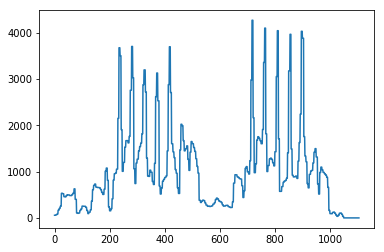

In [19]:
plt.plot(np.sum(s, axis=1))

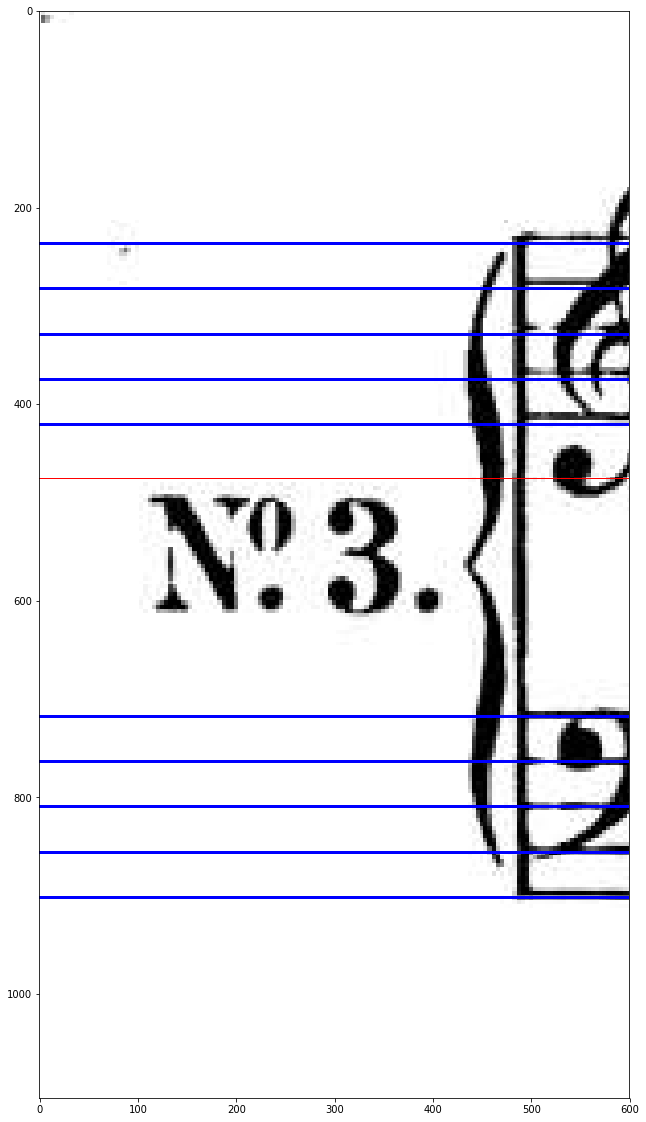

In [20]:
showImage(s[:,0:600], sz=(20,20))
for line in lines:
    plt.axhline(y = line, color='blue', linewidth=3)
plt.axhline(y = estC4, color='r', linewidth=1)
plt.show()

### Notehead Detector

In [21]:
model = DWD(input_shape=(500,500,1), n_classes=124)
model.load_weights('sheet_id/dwd-re-finetune-20000.h5')

In [22]:
# Compute staff height
staff_height = lines[4] - lines[0]

# Flip the color
img = 255 - (255*s).astype('uint8')

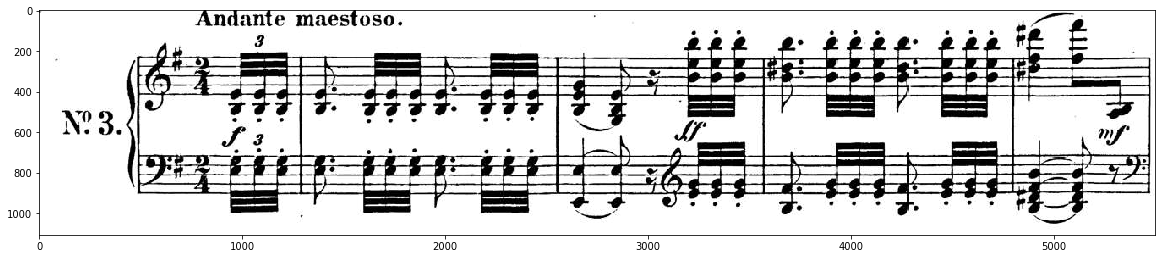

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(img, cmap='gray')

In [24]:
# Rescale the image
scale = 104.5/20
img2 = zoom(img, scale).astype('uint8')

/home/mjenrungrot/anaconda3/envs/spring2019/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


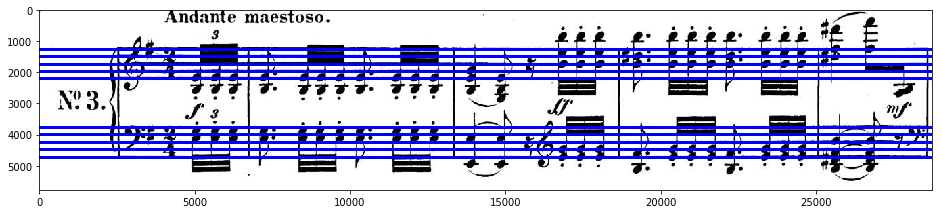

In [25]:
plt.figure(figsize=(16,16))
plt.imshow(img2, cmap='gray')
for line in lines:
    plt.axhline(y = line * scale, color='blue', linewidth=3)

In [26]:
energy_map, class_map, bbox_map = generateFullpagePrediction(model, img2)

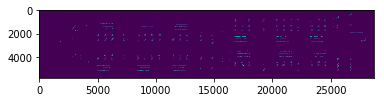

In [27]:
plt.imshow(energy_map)

In [28]:
boxes, scores = inferBoundingBoxes(energy_map, class_map, bbox_map, threshold_binarization=4, 
                                   non_max_suppression_factor=0.25)

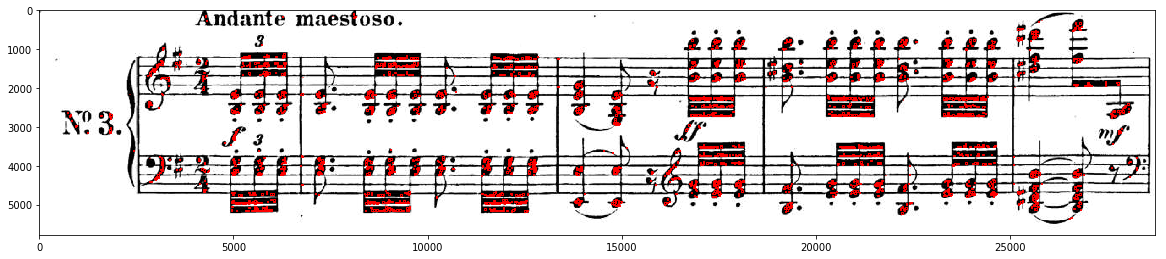

In [29]:
visualizeBoundingBoxes(img2, boxes)

### Synthesize sheet music from notehead detector

In [30]:
def synthesizeSheetNotehead(img, boxes, lines, scale):
    # Generate empty canvas
    synthesized_image = np.zeros_like(img)
    
    # Add notehead
    for box in boxes:
        (x1,y1,x2,y2,cl) = box
        x1 = int(x1/scale)
        x2 = int(x2/scale)
        y1 = int(y1/scale)
        y2 = int(y2/scale)
        synthesized_image = cv2.rectangle(synthesized_image, (x1,y1), (x2,y2), 255, -1)

    return synthesized_image

In [31]:
def convertNoteheadAll(strips, MODEL_STAFFHEIGHT=92):
    output = []
    staff_height = findMedianStaffHeight(strips)
    for i in range(len(strips)):
        lines = locateStaffLines(strips[i], min_height=60, max_height=len(strips[i])//4)
        
        scale = MODEL_STAFFHEIGHT/staff_height    
        
        
        img = 255 - (255*strips[i]).astype('uint8')
        img = zoom(img, scale).astype('uint8')
        energy_map, class_map, bbox_map = generateFullpagePrediction(model, img)
        
        boxes, scores = inferBoundingBoxes(energy_map, class_map, bbox_map, threshold_binarization=4, 
                                   non_max_suppression_factor=0.25)
        synth_sheet = synthesizeSheetNotehead(strips[i], boxes, lines, scale)
        synth_sheet *= 1.0/synth_sheet.max()
        output.append(synth_sheet)
    return output

In [32]:
sheetNotehead = convertNoteheadAll(strips)

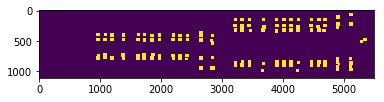

In [33]:
plt.imshow(sheetNotehead[0])

### Synthesize sheet music from midi

In [34]:
def getMidiNoteEvents(midifile, fs = 100):
    mid = MidiFile(midifile)
    tempo = 500000 # default microseconds per beat
    curTimeSec = 0.0
    allEvents = []
    noteEvents = []
    
    for i, track in enumerate(mid.tracks):
        events_temp = []
        curTimeTick = 0
        for msg in track:
            curTimeTick += msg.time
            if msg.type == 'set_tempo':
                tempo = msg.tempo
                events_temp.append(('tempo',curTimeTick, tempo))
            if msg.type == 'note_on' and msg.velocity > 0:
                events_temp.append(('note',curTimeTick, msg.note))
            if msg.type == 'text' and '!!!END:' in msg.text: # ignore command messages that add time at end
                break 
        allEvents = allEvents + events_temp
    allEvents = sorted(allEvents, key=lambda x: x[1])
        
    # Convert accumulated time back to time difference
    allEvents_diff = []
    for i in range(len(allEvents)):
        if i == 0:
            allEvents_diff.append(allEvents[i])
        else:
            allEvents_diff.append((allEvents[i][0], allEvents[i][1]-allEvents[i-1][1], allEvents[i][2]))
    
    # Convert tick to second
    for event in allEvents_diff:
        curTimeSec += mido.tick2second(event[1], mid.ticks_per_beat, tempo)
        if event[0] == 'tempo':
            tempo = event[2]
        else:
            colIdx = np.int(np.round(curTimeSec * fs))
            noteEvents.append((colIdx, event[2]))
    return noteEvents

In [35]:
def synthesizeSheetMusic(noteEvents, strip, zeroPad = 50):
    
    # analyze the strip
    lines = locateStaffLines(strip, min_height=len(strip)//8, max_height=len(strip)//4)
    breakpt = np.int(np.round(.5*(lines[4]+lines[5])))
    upper = strip[0:breakpt,:]
    lower = strip[breakpt:,:]
    m1, b1 = estimateMidiNum2PixelRowMapping(upper, lines[0:5], 'right')
    m2, b2 = estimateMidiNum2PixelRowMapping(lower, lines[5:10] - breakpt, 'left')
    
    # synthesis
    impulses1 = generateNoteImpulses(noteEvents, upper, m1, b1)
    impulses2 = generateNoteImpulses(noteEvents, lower, m2, b2)
    impulses = mergeNoteImpulses(impulses1, impulses2, noteEvents)
    timeAdjusted, timeMapping = adjustMidiTiming(impulses)
    zeroPadded = zeroPadColumns(timeAdjusted, zeroPad, zeroPad)
    filt2d = get2DFilter(np.mean([np.abs(m1),np.abs(m2)]))
    blurred = convolve2d(zeroPadded, filt2d, 'same')
    withLines = np.clip(blurred, 0, 1)
    return withLines, timeMapping

In [36]:
def generateNoteImpulses(noteEvents, strip, m, b):
    synthLen = noteEvents[-1][0] + 1
    impulses = np.zeros((strip.shape[0], synthLen))
    for (timeIdx, midinum) in noteEvents:
        row = estimatePixelRow(midinum, m, b)
        if row >= 0 and row < strip.shape[0]:
            impulses[row, timeIdx] = 1
    return impulses

In [37]:
def mergeNoteImpulses(impulses1, impulses2, noteEvents):
    # This function double checks that whenever a note event occurs, at least one note shows up in the 
    # synthesized score (adding a redundant note if necessary).  This avoids the rare situation where a
    # note event occurs but falls outside of both strips, which leads to midi synthesized scores having
    # different lengths due to shortening of long pauses.
    
    merged = np.vstack((impulses1, impulses2))
    csum = np.sum(merged, axis=0)
    for (timeIdx, midiNote) in noteEvents:
        if csum[timeIdx] == 0:
            merged[0, timeIdx] = 1 # add redundant note
    return merged

In [38]:
def adjustMidiTiming(noteImpulses, maxPauseLen = 50):
    
    # identify long pauses where no onsets occur
    csums = np.sum(noteImpulses, axis=0)   
    dataToInsert = [] # either the index of the column to insert, or -1 for a column of zeros
    isPause = False
    markerStart = 0
    for i in range(len(csums)):
        if isPause:
            if csums[i] != 0 or i == len(csums) - 1: # in a pause, notes occur
                pauseLen = i - markerStart
                if pauseLen > maxPauseLen:
                    dataToInsert.extend([-1] * maxPauseLen)
                else:
                    dataToInsert.extend([-1] * pauseLen)
                dataToInsert.append(i)
                isPause = False
            else: # in a pause, no notes occur
                pass
        else:
            if csums[i] != 0: # not a pause, notes occur
                dataToInsert.append(i)
            else: # not a pause, no notes occur
                isPause = True
                markerStart = i
    
    # reconstruct onset data
    adjusted = np.zeros((noteImpulses.shape[0],len(dataToInsert)))
    for i, col in enumerate(dataToInsert):
        if col == -1:
            pass # leave as zeros
        else:
            adjusted[:,i] = noteImpulses[:,col]
    return adjusted, dataToInsert

In [39]:
def get2DFilter(m):
    filt_sz = np.int(np.round(np.abs(m) * 4))
    filt2d = getBlurFilter(filt_sz, 'block')
    return filt2d

In [40]:
def getBlurFilter(sz, filterType):
    if filterType == 'hamming':
        filt = np.matmul(np.hamming(sz).reshape((sz,1)), np.hamming(sz).reshape(1,sz))
    elif filterType == 'circle':
        filt = np.zeros((sz,sz))
        center = sz/2
        for i in range(sz):
            for j in range(sz):
                if np.sqrt((i-center)*(i-center)+(j-center)*(j-center)) <= center - .01:
                    filt[i,j] = 1
    elif filterType == 'block':
        filt = np.ones((np.int(1.2*sz),np.int(1.125*sz)))
    else:
        print('Unrecognized filter type: %s' % filterType)
        sys.exit(1)
    return filt

In [41]:
def zeroPadColumns(X, nBefore, nAfter):
    h = X.shape[0]
    Y = np.hstack((np.zeros((h,nBefore)), X, np.zeros((h,nAfter))))
    return Y

In [42]:
midiFile = 'midi/mendelssohn_op62no3.mid'
noteEvents = getMidiNoteEvents(midiFile)
midiSynth, _ = synthesizeSheetMusic(noteEvents, s)

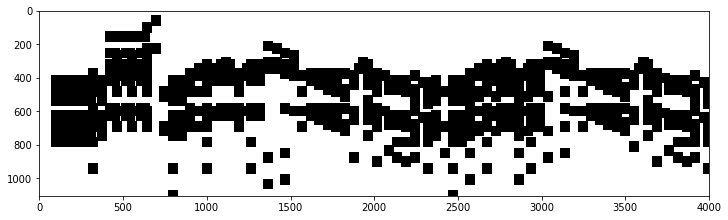

In [43]:
showImage(midiSynth[:,0:4000])

### Align sequence of strips

In [44]:
def downsampleImage(strip, ratio):
    return np.array([[x[i] for i in range(len(x)) if i%ratio == 0] for x in strip])

In [45]:
def alignStripSequence(strips, sheetNotehead, midiFile, zeroPad = 50):
    
    # find optimal fs
    fs = 100.0
    noteEvents = getMidiNoteEvents(midiFile, fs)
    strips = [downsampleImage(s, 3) for s in strips]
    sheetNotehead = [downsampleImage(s, 3) for s in sheetNotehead]
    striplen = np.sum([s.shape[1] for s in strips])
    fs = np.int(fs * striplen / noteEvents[-1][0]) # adjust to get equal lengths
    noteEvents = getMidiNoteEvents(midiFile, fs)
    
    # fill in cost matrix block by block
    Cblocks = []
    midiSynths = []
        
    for i in range(len(strips)):
        midiSynth, timeMapping = synthesizeSheetMusic(noteEvents, strips[i], zeroPad)
        costBlock = -1.0 * np.matmul(sheetNotehead[i].T, midiSynth)
        Cblocks.append(costBlock)
        midiSynths.append(midiSynth)
        
    C = np.vstack(Cblocks)
        
    # DTW
    steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
    weights = np.array([2,3,3])
    D, wp = librosa.core.dtw(C=C, step_sizes_sigma=steps, weights_mul=weights)
    
    return wp[::-1,:], midiSynths, strips, timeMapping, fs

In [46]:
def visualizeAlignedSequences(strips, midiSynths, wp, scoreFile = None, midiFile = None):
    
    # generate panorama of sheet music strips 
    maxH = np.max([s.shape[0] for s in strips])
    pan1 = np.zeros((maxH, wp.shape[0]))
    cumStripLens = np.cumsum([0] + [s.shape[1] for s in strips])
    col2strip = [i for i, s in enumerate(strips) for j in range(s.shape[1])] # column index -> strip index
    for i in range(wp.shape[0]):
        globalIdx = wp[i,0]
        stripIdx = col2strip[globalIdx]
        h = strips[stripIdx].shape[0]
        localIdx = globalIdx - cumStripLens[stripIdx]
        pan1[0:h,i] = strips[stripIdx][:, localIdx] / 255
        
    # generate panorama for midi synthesis
    pan2 = np.zeros((maxH, wp.shape[0]))
    for i in range(wp.shape[0]):
        sheetColIdx = wp[i,0]
        midiColIdx = wp[i,1]
        stripIdx = col2strip[sheetColIdx]
        h = strips[stripIdx].shape[0]
        pan2[0:h, i] = midiSynths[stripIdx][:,midiColIdx]
    
    stacked = np.vstack((pan1, pan2))
    
    # overlay score beat annotations
    if scoreFile:
        with open('gt.pkl', 'rb') as f: # e.g. op68no3_v3
            d = pickle.load(f) 
        scoreRefBeats = d[scoreFile]
        xcoords = np.interp(scoreRefBeats, wp[:,0], range(wp.shape[0]))
        for x in xcoords:
            if not np.isnan(x):
                stacked[0:maxH,np.int(np.round(x))] = .5
    
    # overlay midi beat annotations
    if midiFile:
        with open('gt.pkl', 'rb') as f: # e.g. midi/op68no3/pid1263b-19-avgtapsd0.mid
            d = pickle.load(f) 
        basename = os.path.splitext(os.path.basename(midiFile))[0]
        midiID = '%s--%s' % (scoreFile, basename)
        midiRefBeats = d[midiID]
        print(midiRefBeats)
        xcoords = np.interp(midiRefBeats, wp[:,1], range(wp.shape[0]))
        for x in xcoords:
            if not np.isnan(x):
                stacked[maxH:,np.int(np.round(x))] = .5
    
    return stacked

In [47]:
wp, midiSynths, strips, _, _ = alignStripSequence(strips, sheetNotehead, midiFile)

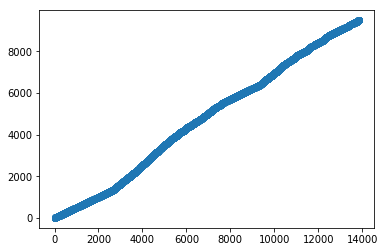

In [48]:
plt.scatter(wp[:,0], wp[:,1])

In [49]:
stacked = visualizeAlignedSequences(strips, midiSynths, wp)

(-0.5, 1999.5, 2751.5, -0.5)

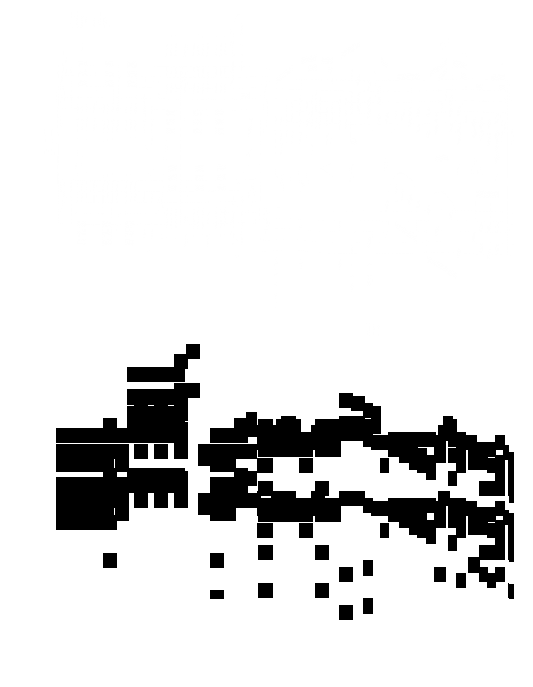

In [50]:
start = 0
end = start+2000
showImage(stacked[:,start:end])
plt.axis('off')

### Align all midi-sheet pairs

In [51]:
pieces = glob.glob('midi/*')
pieces = list(map(lambda x: os.path.splitext(os.path.basename(x))[0], pieces))

error_pieces = []
hyp_dir = 'hyp_align'
if not os.path.exists(hyp_dir):
    os.mkdir(hyp_dir)
    
zeroPad = 50
nhd_sheet_dir = 'nhd_sheet' # directory for storing simplified score generated with notehead detection
if not os.path.exists(nhd_sheet_dir):
    os.mkdir(nhd_sheet_dir)
    
bs_sheet_dir = 'bs_sheet' # directory for storing bootleg score generated from midi
if not os.path.exists(bs_sheet_dir):
    os.mkdir(bs_sheet_dir)

for piece in tqdm_notebook(pieces):  # for every pair of matching scores

    scores = [os.path.basename(elem) for elem in sorted(glob.glob('score_data/prepped_png/%s*' % piece))]
    midifiles = [m for m in sorted(glob.glob('midi/%s.mid' % piece))]
    for score in scores:
        strips = loadStripData(score)
        strips = [rotateToHorizontal(s) for s in strips]
        striplens = [s.shape[1] for s in strips]
        for i, midifile in enumerate(midifiles):
            midiID = os.path.splitext(os.path.basename(midifile))[0]
            outfile = '%s/%s.pkl' % (hyp_dir, score)
            if not os.path.exists(outfile):
                try:
                    nhd_sheet_file = nhd_sheet_dir+'/'+score+'.pkl'
                    print(nhd_sheet_file)
                    if os.path.exists(nhd_sheet_file):
                        dhyp = pickle.load(open(nhd_sheet_file, 'rb'))
                        sheetNotehead = dhyp['sheetNotehead']
                    else:
                        sheetNotehead = convertNoteheadAll(strips)
                        with open(nhd_sheet_file,'wb') as f:
                            pickle.dump({'sheetNotehead': sheetNotehead}, f)

                    wp, midiSynths, strips, timeMapping, fs = alignStripSequence(strips, sheetNotehead, midifile, zeroPad)
                        
                except ValueError:
                    error_pieces.append(piece)
                    print("Encounter an error piece [ValueError] {:} [Total num = {:}]".format(piece, len(error_pieces)))
                    continue
                except MemoryError:
                    error_pieces.append(piece)
                    print("Encounter an error piece [MemoryError] {:} [Total num = {:}]".format(piece, len(error_pieces)))
                    continue

                with open(outfile,'wb') as f:
                    pickle.dump({'wp':wp,'striplens':striplens,'fs':fs,'zeroPad':zeroPad,'timeMapping':timeMapping}, f)
                    
                visualize_outfile = '%s/%s.pkl' % (bs_sheet_dir, score)
                with open(visualize_outfile,'wb') as f:
                    pickle.dump({'strips':strips,'midiSynths':midiSynths,'wp':wp}, f)
            else:
                print('Already aligned!')
            print('Processed %d of %d, %s' % (i+1, len(midifiles), score))
    # garbage collection
    gc.collect()

Already aligned!
Processed 1 of 1, chopin_op63no3_v1
Already aligned!
Processed 1 of 1, chopin_op63no3_v2
Already aligned!
Processed 1 of 1, chopin_op63no3_v3
Already aligned!
Processed 1 of 1, chopin_op63no3_v4
Already aligned!
Processed 1 of 1, chopin_op63no3_v5
Already aligned!
Processed 1 of 1, chopin_op63no3_v6
Already aligned!
Processed 1 of 1, chopin_op30no2_v1
Already aligned!
Processed 1 of 1, chopin_op30no2_v2
Already aligned!
Processed 1 of 1, chopin_op30no2_v3
Already aligned!
Processed 1 of 1, chopin_op30no2_v4
Already aligned!
Processed 1 of 1, chopin_op30no2_v5
Already aligned!
Processed 1 of 1, chopin_op30no2_v6
Already aligned!
Processed 1 of 1, clementi_op36no1mv3_v1
Already aligned!
Processed 1 of 1, clementi_op36no1mv3_v2
Already aligned!
Processed 1 of 1, debussy_childrencorner1_v1
Already aligned!
Processed 1 of 1, debussy_childrencorner1_v2
Already aligned!
Processed 1 of 1, debussy_childrencorner1_v3
Already aligned!
Processed 1 of 1, clementi_op36no3mv3_v1
Alre

/home/mjenrungrot/anaconda3/envs/spring2019/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processed 1 of 1, chopin_op68no3_v2
nhd_sheet/chopin_op68no3_v3.pkl
Processed 1 of 1, chopin_op68no3_v3
nhd_sheet/chopin_op68no3_v4.pkl
Processed 1 of 1, chopin_op68no3_v4
nhd_sheet/chopin_op68no3_v5.pkl
Processed 1 of 1, chopin_op68no3_v5
nhd_sheet/chopin_op68no3_v6.pkl
Processed 1 of 1, chopin_op68no3_v6
nhd_sheet/mendelssohn_op19no2_v1.pkl
Processed 1 of 1, mendelssohn_op19no2_v1
nhd_sheet/mendelssohn_op19no2_v2.pkl
Processed 1 of 1, mendelssohn_op19no2_v2
nhd_sheet/mendelssohn_op19no2_v3.pkl
Processed 1 of 1, mendelssohn_op19no2_v3
nhd_sheet/mendelssohn_op19no2_v4.pkl
Processed 1 of 1, mendelssohn_op19no2_v4
nhd_sheet/mendelssohn_op19no2_v5.pkl
Processed 1 of 1, mendelssohn_op19no2_v5
nhd_sheet/brahms_op117no2_v1.pkl
Processed 1 of 1, brahms_op117no2_v1
nhd_sheet/brahms_op117no2_v2.pkl
Processed 1 of 1, brahms_op117no2_v2
nhd_sheet/brahms_op117no2_v3.pkl
Processed 1 of 1, brahms_op117no2_v3
nhd_sheet/brahms_op117no2_v4.pkl
Processed 1 of 1, brahms_op117no2_v4
nhd_sheet/schubert_op9